# Moments Basics

In this section we will take a look at the basics of using moments to measure shapes.


```{note}
Try out the interactive version of this notebook on Binder!
```

<a href="https://mybinder.org/v2/gh/sfarrens/Shear-and-PSF-Reading-Group/book/?urlpath=tree/moments_interact.ipynb" target="_blank"><img src="https://img.shields.io/badge/launch-binder-579aca.svg?logo=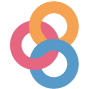"></a>

In [1]:
import numpy as np
from plot import *
from data import * 
from IPython.display import Markdown as md
from interact import get_url, binder_badge

url = get_url('moments')
md('<a href="{}" target="_blank"><img src="{}"></a>'.format(get_url('moments'), binder_badge))

## Example Data

Let's begin by looking at some dummy images with properties we can easily discern by eye. We will use the `data_dict` imported from `data.py` (see [appendix](content:appendix)) and print the available keys.

In [2]:
for key in data_dict.keys():
    print(key)

Horizontal Line
Vertical Line
Diagonal Line (Up)
Diagonal Line (Down)
Circle
Circle (Off-Centre)


Now we can examime the content of the matrices that define the images.

In [3]:
data_name = 'Diagonal Line (Down)'
print(data_dict[data_name])

[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


```{admonition} Hint
:class: tip
Try changing `data_name` to one of the other possible dictionary keys to compare the matrices.
```

What you should notice is that we have a collection of (very unrealistic) images with a range of orientions and ellipticities. We can use these images to verify in the following sections that we fully understand how to measure the shape of an object using moments.

## Image Flux Density

We can define the flux density or surface brightness, $I$, of an object as the amount of light (*i.e.* flux) per square arcsecond on the sky. $I(x, y)$ gives the flux density at position $x, y$, which we can relate to a given pixel. To measure the full surface brightness of an object we need to intragte acoss the whole image

$$F = \int I(x,y) dx dy$$ (total_flux)

or for a discrete set of pixels sum the values of $I(x, y)$.

$$F = \sum_{x,y} I(x,y)$$ (total_flux_discrete)

Let's 

In [4]:
print('F = {}'.format(np.sum(data_dict['Horizontal Line'])))

F = 3.0


## Centroid

Now that we have established what the surface brightness is we can use it identfy the first moment or centroid $(\bar{x}, \bar{y})$ of a given image.

$$
    \bar{x} = \frac{\sum_{x,y} xI(x,y)}{\sum_{x,y} I(x,y)}
$$ (centroid_x)

$$
    \bar{y} = \frac{\sum_{x,y} yI(x,y)}{\sum_{x,y} I(x,y)}
$$ (centroid_y)


The following cell provides a simple implementation of equations {eq}`centroid_x` and {eq}`centroid_y`.

In [5]:
def get_centroid(data):
    
    # Sum flux over x and y individually
    sum_i = np.array([np.sum(data, axis=i) for i in (1, 0)])
    
    # Get range of x and y values
    ranges = np.array([np.arange(i) for i in data.shape])
    
    # Calculate centroids
    cents = np.sum(sum_i * ranges, axis=1) / np.sum(data)
    
    return cents.astype(int)

Now let's test that our function works on the example data.

In [6]:
def show_centroid(data_name):
    
    data = data_dict[data_name]
    centroid = get_centroid(data)
    
    show_image(data, centroid=centroid)

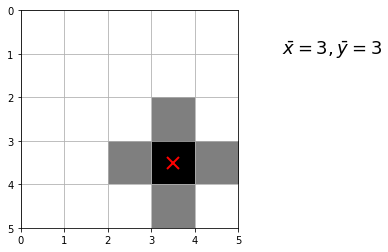

In [7]:
show_centroid('Circle (Off-Centre)')

We can see that, regardless of the position of the image within the postage stamp, the centroid (highlighted with a red x) is always correctly determined.

## Moments

Finally, we can define the second moment or quadrupole moments of an image as follows.

$$
    Q_{xy} = \frac{\sum_{x,y} I(x,y)(x - \bar{x})(y - \bar{y})}{\sum_{x,y} I(x,y)}
$$ (moments)

Equation {eq}`moments` is used to determine object shapes. In the following cell we a simple implementation of this equation.

In [8]:
def get_moments(data):
    
    centroid = get_centroid(data)
    ranges = np.array([np.arange(i) for i in data.shape])
    
    x = np.outer(ranges[0] - centroid[0], np.ones(data.shape[1]))
    y = np.outer(np.ones(data.shape[0]), ranges[1] - centroid[1])
    
    q = np.array([np.sum(data * xi * xj) for xi in (x, y) for xj in (x, y)])
    q = (q / np.sum(data)).reshape(2, 2).astype('complex')
    
    return q

We can examine the output of this function for the various example images.

In [9]:
print(get_moments(data_dict['Vertical Line']))

[[0.66666667+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]


While it is clear that the moments are different for each image, it can be difficult to interpret these numbers.

## Measures of Ellipticity

It is convenient to convert these moments into a measure of the object's *ellipticity*, however this can be done in various ways.

### Polarisation

This is the standard convetion used by methods such as KSB and is often denoted by the greek letter $\chi$.

$$
    \chi = \frac{Q_{00}-Q_{11}+2iQ_{01}}{Q_{00}+Q_{11}}
$$ (chi)

### Ellipticity

This is an alternative convention that... and is often denoted by the greek letter $\epsilon$.

$$
    \epsilon = \frac{Q_{00}-Q_{11}+2iQ_{01}}{Q_{00}+Q_{11}+2\sqrt{Q_{00}Q_{11}-Q_{01}^2}}
$$ (epsilon)

```{note}
We have adopted the convention of labeling $Q_{x, y}$ starting from $x, y$ = 0 to keep the equations consistent with the code.
```

The following cell provides a simple implementation of both {eq}`chi` and {eq}`epsilon`.

In [10]:
def get_ellipticity(data, method='chi'):
    
    # Calculate moments
    q = get_moments(data)
    
    # Calculate the image size.
    r2 = q[0, 0] + q[1, 1]

    # Calculate the numerator
    num = (q[0, 0] - q[1, 1] + 2 * np.complex(0, q[0, 1]))
    
    # Calculate the denominator
    den = r2
    
    if method == 'epsilon':
        den += 2 * np.sqrt(q[0, 0] * q[1, 1] - q[0, 1] ** 2)
    
    # Calculate the ellipticity/polarisation
    ellip = num / den

    return np.around([ellip.real, ellip.imag], 3)

The ellipticity makes it a bit easier to interpret the properties of the example images.

In [11]:
def show_ellipticity(data_name):
    
    data = data_dict[data_name]
    centroid = get_centroid(data)
    chi = get_ellipticity(data)
    epsilon = get_ellipticity(data, method='epsilon')
    
    show_image(data, centroid=centroid, chi=chi, epsilon=epsilon)

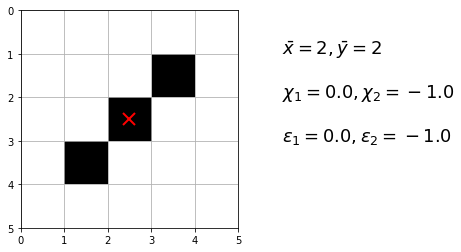

In [12]:
show_ellipticity('Diagonal Line (Up)')

### Semi-Major/Minor Axes

It is also possible to relate the quadrupole moments to more traditional measures of ellipticity, namely the semi-major axis ($a$), semi-minor axis ($b$) and angle ($\theta$).

$$
    a^2 = \frac{Q_{00}+Q_{11}+\sqrt{(Q_{00}-Q_{11})^2 + 4Q_{01}^2}}{2}
$$ (semi-major)

$$
    b^2 = \frac{Q_{00}+Q_{11}-\sqrt{(Q_{00}-Q_{11})^2 + 4Q_{01}^2}}{2}
$$ (semi-minor)

$$
\begin{equation}
	\theta = 
	\begin{cases} 
        \frac{\pi}{4} & \text{if}~ Q_{00}-Q_{11} = 0 \\
        \frac{1}{2}\arctan(\frac{2Q_{01}}{Q_{00}-Q_{11}}) & \text{if}~ Q_{00}-Q_{11} \neq 0 \\ 
		\frac{1}{2}\arctan(\frac{2Q_{01}}{Q_{00}-Q_{11}}) + \frac{\pi}{2} & \text{if}~ Q_{00}-Q_{11} > 0 ~ \text{and} ~  Q_{01}, Q_{10} = 0 \\ 
        \frac{1}{2}\arctan(\frac{2Q_{01}}{Q_{00}-Q_{11}}) - \frac{\pi}{2}\text{sign}(Q_{01}) & \text{if}~ Q_{00}-Q_{11} > 0 ~ \text{and} ~  Q_{01}, Q_{10} \neq 0 \\ 
	\end{cases}
	\label{eq:soft}
\end{equation}
$$ (rotation-angle)

The following cell implements equations {eq}`semi-major`, {eq}`semi-minor` and {eq}`rotation-angle`.

In [13]:
def get_abt(data):
    
    q = get_moments(data)
    
    qq_plus = q[0, 0] + q[1, 1]
    qq_minus = q[0, 0] - q[1, 1]
    root = np.sqrt(qq_minus ** 2 + 4 * q[0, 1] ** 2)
    
    a = np.around(np.real(np.sqrt(0.5 * (qq_plus + root))), 3)
    b = np.around(np.real(np.sqrt(0.5 * (qq_plus - root))), 3)
    if qq_minus == 0.0:
        theta = -45.0 * np.sign(np.real(q[0, 1]))
    else:
        theta = np.around(np.real(0.5 * np.arctan(2 * q[0, 1] / qq_minus)) * 180. / np.pi, 3)
        
    if qq_minus > 0.0 and q[0, 1] == 0.0:
        theta += 90.0
    elif qq_minus > 0.0:
        theta -= 90.0 * np.sign(np.real(q[0, 1]))
    
    return a, b, theta

We can test the accuracy of this implementation by generating some images where we define the properties of the ellipse and seeing if we can recover the correct model from the moments.

In [14]:
def show_ellipse(a, b, theta):
    
    data = make_ellipse(a, b, theta)
    centroid = get_centroid(data)
    chi = get_ellipticity(data)
    epsilon = get_ellipticity(data, method='epsilon')
    abt = get_abt(data)
    
    show_image(data, centroid=centroid, chi=chi, epsilon=epsilon, abt=abt)

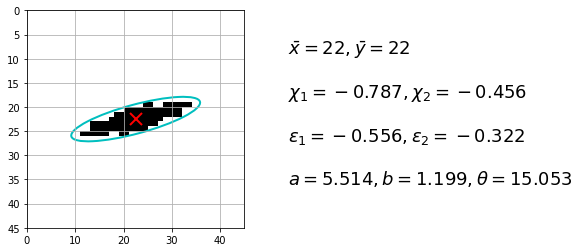

In [15]:
show_ellipse(a=5, b=1, theta=15)

```{note}
Refer to the [appendix](content:appendix) to see how the input images are produced.
```